문제 : https://dacon.io/competitions/official/235689/overview/description/

출처 : https://dacon.io/codeshare/2396?page=1&dtype=recent&s_id=0

In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/MyDrive/dacon/운동 동작 분류 AI 경진대회

[Errno 2] No such file or directory: 'drive/MyDrive/dacon/운동 동작 분류 AI 경진대회'
/content/drive/MyDrive/dacon/운동 동작 분류 AI 경진대회


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings(action='ignore') # 경고 메세지 숨기기

## Data loading

In [ ]:
train = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test_features.csv')

submission = pd.read_csv('sample_submission.csv')

pd.options.display.max_columns=50 # df 너비 조정

In [ ]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [ ]:
train_labels.head()

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise


**[데이터]**

3축 가속도계(accelerometer)와 3축 자이로스코프(gyroscope)를 활용해 측정된 센서 데이터

- train_features.csv (1875000, 8)  
  - id 별 600 time 간 동작 데이터  
  - id 3125개 x 600 time =1875000 데이터

- train_labels.csv (3125, 3)  
  - id 별 동작과 동작 label(61개)

- test_features.csv (469200, 8)  
  - id 별 600 time간 동작 데이터  
  - id 782개 x 600 time =469200 데이터

- sample_submission.csv (782, 62)  
  - id별 동작을 예측해 작성하는 csv

## Feature engneering
가속도, 자이로, (자이로-가속도) 센서값을 에너지로 표현

In [ ]:
train['acc_Energy']=(train['acc_x']**2+train['acc_y']**2+train['acc_z']**2)**(1/3)
test['acc_Energy']=(test['acc_x']**2+test['acc_y']**2+test['acc_z']**2)**(1/3)

train['gy_Energy']=(train['gy_x']**2+train['gy_y']**2+train['gy_z']**2)**(1/3)
test['gy_Energy']=(test['gy_x']**2+test['gy_y']**2+test['gy_z']**2)**(1/3)

train['gy_acc_Energy']=((train['gy_x']-train['acc_x'])**2+(train['gy_y']-train['acc_y'])**2+(train['gy_z']-train['acc_z'])**2)**(1/3)
test['gy_acc_Energy']=((test['gy_x']-test['acc_x'])**2+(test['gy_y']-test['acc_y'])**2+(test['gy_z']-test['acc_z'])**2)**(1/3)

In [ ]:
train.head() # 에너지 표현 변수 생성

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.146962,12.465436,12.427938
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.200703,12.913284,12.865692
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.217403,13.725729,13.692643
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.209981,15.374021,15.314907
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.211254,16.074363,16.017964


In [ ]:
# id별 데이터는 0.02초마다 측정된 값들이기 때문에 이전 시간 대비 변화량 적용

dt=0.02 
def jerk_signal(signal): 
        return np.array([(signal[i+1]-signal[i])/dt for i in range(len(signal)-1)])

In [ ]:
train_dt=[]
for i in tqdm(train['id'].unique()):
    temp=train.loc[train['id']==i]
    for v in train.columns[2:]:
        values=jerk_signal(temp[v].values)
        values=np.insert(values,0,0)
        temp.loc[:,v+'_dt']=values
    train_dt.append(temp)

100%|██████████| 3125/3125 [00:47<00:00, 65.72it/s]


In [ ]:
test_dt=[]
for i in tqdm(test['id'].unique()):
    temp=test.loc[test['id']==i]
    for v in train.columns[2:]:
        values=jerk_signal(temp[v].values)
        values=np.insert(values,0,0)
        temp.loc[:,v+'_dt']=values
    test_dt.append(temp)

100%|██████████| 782/782 [00:10<00:00, 71.28it/s]


In [ ]:
# 가속도, 자이로 센서값들을 푸리에 변환

from scipy import fftpack
from numpy.fft import *

def fourier_transform_one_signal(t_signal):
    complex_f_signal= fftpack.fft(t_signal)
    amplitude_f_signal=np.abs(complex_f_signal)
    return amplitude_f_signal

<푸리에>  
변환 시간이나 공간에 대한 함수를 시간 또는 공간 주파수 성분으로 분해하는 변환 


간단하게 말해서 어떤 임의의 입력신호를 다양한 주파수의 주기함수들 합으로 표현한 것 ( ex. sin, cos )


[참고](https://darkpgmr.tistory.com/171)

In [ ]:
train=pd.concat(train_dt)

In [ ]:
fft=[]
for i in tqdm(train['id'].unique()):
    temp=train.loc[train['id']==i]
    for i in train.columns[2:8]:
        temp[i]=fourier_transform_one_signal(temp[i].values)
    fft.append(temp)
train=pd.concat(fft)

100%|██████████| 3125/3125 [00:11<00:00, 281.76it/s]


In [ ]:
test=pd.concat(test_dt)

In [ ]:
fft_t=[]
for i in tqdm(test['id'].unique()):
    temp=test.loc[test['id']==i]
    for i in test.columns[2:8]:
        temp[i]=fourier_transform_one_signal(temp[i].values)
    fft_t.append(temp)
test=pd.concat(fft_t)

100%|██████████| 782/782 [00:01<00:00, 435.44it/s]


In [ ]:
# Standard scaling 적용

col=train.columns
train_s=train.copy()
test_s=test.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()

train_s.iloc[:,2:]= scaler.fit_transform(train_s.iloc[:,2:])
train_sc = pd.DataFrame(data = train_s,columns =col)

test_s.iloc[:,2:]= scaler.transform(test_s.iloc[:,2:])
test_sc = pd.DataFrame(data = test_s,columns =col)

In [ ]:
train_sc

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,27.356382,8.807207,19.465910,0.376992,0.869226,0.150423,0.495681,-0.272719,-0.276391,0.000027,0.000298,-0.000433,0.000347,0.000373,0.000273,0.000101,0.001505,0.001501
1,0,1,-0.054866,0.833464,0.820412,-0.282128,-0.093560,0.011266,0.742974,-0.236152,-0.240632,0.416836,-0.118821,-0.255054,0.032738,-0.349095,0.377085,0.564992,0.166566,0.162871
2,0,2,0.024046,0.315921,0.081086,-0.182551,-0.053585,-0.003708,0.819822,-0.169815,-0.173080,0.086405,0.023750,-0.531727,-0.141582,-0.202368,-0.004887,0.175645,0.300944,0.306341
3,0,3,0.065632,0.117634,-0.040874,-0.194863,0.154242,0.005408,0.785669,-0.035229,-0.040560,-0.058780,-0.213920,0.285459,0.229520,-0.385106,-0.135647,-0.077915,0.609008,0.599518
4,0,4,0.151477,0.300751,0.317742,-0.350724,0.494539,0.154354,0.791528,0.021954,0.016872,0.039823,0.259227,-0.055206,0.057320,-0.174917,-0.028047,0.013483,0.259626,0.260669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,0.365037,0.011656,0.845701,0.080839,0.350395,0.112282,-0.138940,0.829394,0.823900,0.151679,0.037205,0.119409,-0.108728,-0.027804,-0.009085,-0.142794,0.063329,0.063674
1874996,3124,596,10.220817,5.476964,7.441373,3.605246,16.530576,11.843241,-0.167578,0.814816,0.809618,0.150658,-0.000363,0.265559,-0.027936,0.090560,-0.018412,-0.065316,-0.064300,-0.062949
1874997,3124,597,0.386337,0.177768,-0.080193,-0.192468,-0.033904,-0.227861,-0.151875,0.802027,0.797338,0.093524,-0.049283,0.260884,0.082744,0.123264,-0.152712,0.035970,-0.056225,-0.053918
1874998,3124,598,0.728823,0.014037,0.350745,0.136284,1.281790,0.403540,-0.175811,0.801880,0.797431,0.174681,-0.096564,0.071332,0.153722,-0.014412,-0.049662,-0.054574,0.000843,0.001922


## 모델링

- CNN, LSTM, CNN+LSTM 등 여러 구조 적용해보다가 CNN에서 Flatten 없이 Global average pooling 한 구조가 가장 성능이 좋아 채택했습니다.

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, LSTM,Bidirectional,Dropout
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.model_selection import KFold,StratifiedKFold
from numpy.random import seed
import keras

In [ ]:
X=np.array(train_sc.iloc[:,2:]).reshape(3125, 600, -1)   # id 3125, time이 600
X.shape

(3125, 600, 18)

In [ ]:
test_x=np.array(test_sc.iloc[:,2:]).reshape(782, 600, -1)
test_x.shape

(782, 600, 18)

In [ ]:
y = train_labels['label'].values
y = tf.keras.utils.to_categorical(train_labels['label']) # one hot encoding?
y.shape

(3125, 61)

< CNN >

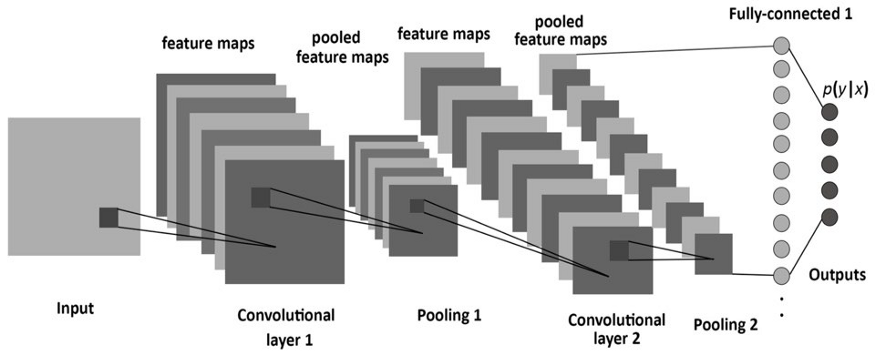

In [ ]:
# 모델 구조

def cnn_model(input_shape, classes):
    seed(2021)
    tf.random.set_seed(2021) 
    
    input_layer = keras.layers.Input(input_shape)
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=9, padding='same')(input_layer)  # 1D CNN  
    # padding = same : 출력값 크기가 입력값과 동일하게 자동으로 Padding 시켜줌
    conv1 = keras.layers.BatchNormalization()(conv1) # BatchNormalization
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    conv1 = keras.layers.Dropout(rate=0.3)(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=6, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)
    conv2 = keras.layers.Dropout(rate=0.4)(conv2)
    
    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)
    conv3 = keras.layers.Dropout(rate=0.5)(conv3)
    # 3개의 convolutional 층??

    gap = keras.layers.GlobalAveragePooling1D()(conv3)  # feature를 1차원 벡터로 
    
    output_layer = keras.layers.Dense(classes, activation='softmax')(gap)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(), 
        metrics=['accuracy'])
    
    return model

[Convolution - Batch Normalization - Activation - Dropout - Pooling] 순서로 구성된 네트워크  

- [1D CNN](https://wikidocs.net/80437)

- padding  
  데이터가 줄어드는 것을 방지하기 위해 입력데이터 외의 특정값을 넣는 것

- [BN](https://m.blog.naver.com/laonple/220808903260)  
  whitening과 비슷하지만 다름, 입력을 정규화 한 후 감마와 벡터를 추가.
  - covariate shift (공변량 이동) : train data와 test data의 분산이 달라지는 것? -> 훈련된 모델이 test data에 잘 맞지 않음  
    ex) 늙은 얼굴로 훈련시킨 모델로 젊은 얼굴 분류???

- [Pooling & global average pooling](https://gaussian37.github.io/dl-concept-global_average_pooling/)

< padding >

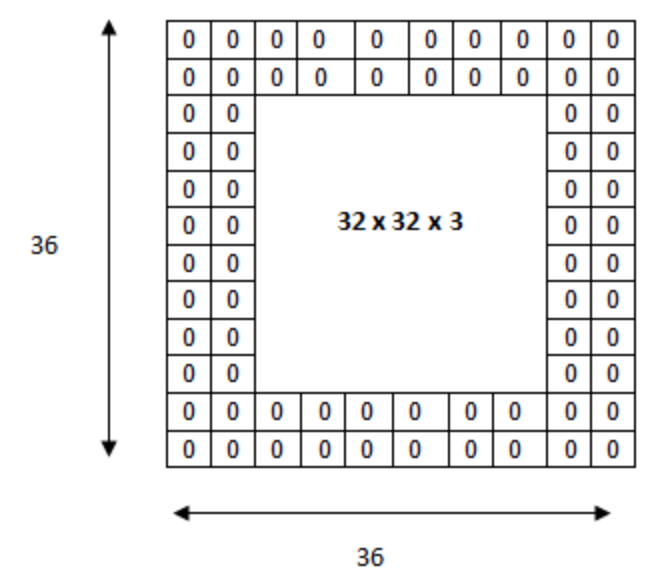

< 대표적 손실함수 & 활성화함수 조합 >

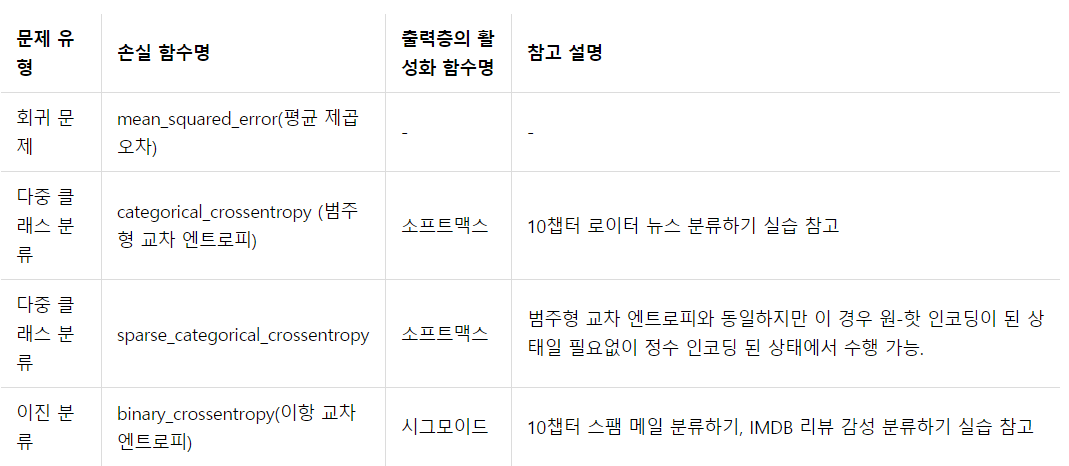

In [ ]:
# 10-fold StratifiedKFold

skf = StratifiedKFold(n_splits = 10, random_state = 2021, shuffle = True)  # 교차검증을 할때 데이터 라벨의 분포를 고르게 해주는 것
reLR = ReduceLROnPlateau(patience = 4,verbose = 1,factor = 0.5) # 콜백 함수
# patience = epoch n개 동안 개선되지 않으면 call back 호출
# factor = 콜백함수 호출 시 학습률을 1/2로 줄임
es =EarlyStopping(monitor='val_loss', patience=8, mode='min')

accuracy = []
losss=[]
models=[]

for i, (train, validation) in enumerate(skf.split(X, y.argmax(1))) :
    mc = ModelCheckpoint(f'./model_kf/cv_study{i + 1}.h5',save_best_only=True, verbose=0, monitor = 'val_loss', mode = 'min', save_weights_only=True)
    print("-" * 20 +"Fold_"+str(i+1)+ "-" * 20)
    model = cnn_model((600,18),61)
    history = model.fit(X[train], y[train], epochs = 100, validation_data= (X[validation], y[validation]), 
                        verbose=1,batch_size=64,callbacks=[es,mc,reLR])
    model.load_weights(f'./model_kf/cv_study{i + 1}.h5')
    
    k_accuracy = '%.4f' % (model.evaluate(X[validation], y[validation])[1])
    k_loss = '%.4f' % (model.evaluate(X[validation], y[validation])[0])
    
    accuracy.append(k_accuracy)
    losss.append(k_loss)
    models.append(model)

print('\nK-fold cross validation Auc: {}'.format(accuracy))
print('\nK-fold cross validation loss: {}'.format(losss))

--------------------Fold_1--------------------
Epoch 1/100
44/44 [==============================] - 3s 53ms/step - loss: 3.3854 - accuracy: 0.3492 - val_loss: 3.1192 - val_accuracy: 0.3099
Epoch 2/100
44/44 [==============================] - 2s 48ms/step - loss: 1.9730 - accuracy: 0.5509 - val_loss: 1.9230 - val_accuracy: 0.5335
Epoch 3/100
44/44 [==============================] - 2s 48ms/step - loss: 1.7848 - accuracy: 0.5647 - val_loss: 2.0431 - val_accuracy: 0.5495
Epoch 4/100
44/44 [==============================] - 2s 47ms/step - loss: 1.5550 - accuracy: 0.6141 - val_loss: 1.9246 - val_accuracy: 0.5623
Epoch 5/100
44/44 [==============================] - 2s 48ms/step - loss: 1.3833 - accuracy: 0.6462 - val_loss: 1.5128 - val_accuracy: 0.6070
Epoch 6/100
44/44 [==============================] - 2s 48ms/step - loss: 1.2679 - accuracy: 0.6755 - val_loss: 1.4047 - val_accuracy: 0.6230
Epoch 7/100
44/44 [==============================] - 2s 48ms/step - loss: 1.1640 - accuracy: 0.6893 -

- [kfold 교차검증](https://velog.io/@skyepodium/K-Fold-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D#4-stratifiedkfold)

- [콜백함수](https://teddylee777.github.io/tensorflow/keras-%EC%BD%9C%EB%B0%B1%ED%95%A8%EC%88%98-vol-01)  
  나중에 호출되는 함수, 어떠한 사건이 터졌을때 호출되는 함수
  - [ReduceLROnPlateau](https://deep-deep-deep.tistory.com/56)  
    모델의 개선이 없을 경우, Learning Rate를 조절해 모델의 개선을 유도하는 함수
  - [EarlyStopping](https://3months.tistory.com/424)  
    무조건 Epoch 을 많이 돌린 후, 특정 시점에서 멈추는 것
  - [ModelCheckpoint](https://deep-deep-deep.tistory.com/53)  
    조건을 만족했을 때 Model의 weight 값을 중간 저장

## 성능 확인

In [ ]:
print(sum([float(i) for i in accuracy])/10)
print()
print(sum([float(i) for i in losss])/10)

0.85344

0.48245000000000005


In [ ]:
test_X=np.array(test_sc.iloc[:,2:]).reshape(782, 600, -1)
test_X.shape

(782, 600, 18)

In [ ]:
preds = []
for model in models:
    pred = model.predict(test_X)
    preds.append(pred)
pred = np.mean(preds, axis=0)
pred

array([[8.8815195e-06, 1.6437394e-06, 1.2019392e-07, ..., 5.0459327e-03,
        1.2703602e-05, 2.0145728e-06],
       [4.3004059e-04, 2.3920458e-05, 1.1793636e-04, ..., 8.0875370e-06,
        1.9087403e-05, 1.4260508e-05],
       [1.9237977e-03, 3.1819437e-02, 1.8673640e-05, ..., 8.3544757e-04,
        1.1031318e-02, 2.3675081e-03],
       ...,
       [4.8005130e-04, 3.8012972e-06, 1.1856716e-05, ..., 2.1082587e-05,
        1.6631553e-06, 9.7771874e-04],
       [3.7510811e-06, 8.2720316e-04, 8.0982500e-07, ..., 6.4340000e-08,
        1.2029674e-05, 3.4328909e-09],
       [9.8187375e-05, 4.8118150e-06, 1.1237279e-06, ..., 1.0782595e-04,
        9.3269307e-07, 1.7123987e-04]], dtype=float32)

In [ ]:
submission=pd.read_csv('./sample_submission.csv')
submission.iloc[:,1:]=pred
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,...,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000009,0.000002,1.201939e-07,1.868766e-08,1.794730e-04,8.881354e-08,2.858338e-04,0.000002,1.254895e-07,0.005659,9.128784e-02,4.841591e-01,1.178032e-04,3.989666e-01,1.934411e-03,3.017379e-06,1.887888e-06,5.266290e-07,2.827206e-07,7.526629e-08,2.751505e-05,0.000002,5.967191e-07,0.004765,...,0.000943,8.074475e-04,7.661267e-05,1.086470e-05,2.207086e-07,4.465582e-09,0.000251,0.000055,3.297021e-05,6.442192e-04,3.362881e-05,7.169418e-08,2.563549e-06,1.720764e-06,1.840529e-08,4.449211e-04,5.014882e-04,1.186973e-05,1.813073e-06,1.064860e-07,1.543243e-07,7.581326e-10,5.045933e-03,1.270360e-05,2.014573e-06
1,3126,0.000430,0.000024,1.179364e-04,1.176697e-03,5.085496e-05,5.761566e-04,3.150068e-06,0.000068,7.595086e-06,0.000013,2.312030e-05,1.740476e-06,1.497593e-08,2.082086e-06,1.025060e-06,3.011212e-04,2.910053e-05,1.073731e-05,1.849242e-05,3.728820e-06,2.593143e-05,0.000184,1.966052e-03,0.000205,...,0.000316,6.343785e-06,2.199874e-06,4.257803e-08,4.630831e-04,3.386324e-04,0.000014,0.000007,1.807016e-06,4.017278e-06,9.215897e-06,1.811570e-05,1.241412e-04,2.323224e-03,6.336272e-04,8.018691e-06,1.766217e-08,8.480960e-05,1.761592e-04,1.124073e-04,3.562416e-06,1.506893e-04,8.087537e-06,1.908740e-05,1.426051e-05
2,3127,0.001924,0.031819,1.867364e-05,9.027706e-06,3.475575e-05,6.374883e-04,1.105062e-01,0.000158,1.894083e-05,0.000047,1.929773e-03,4.449778e-04,3.594266e-05,2.789290e-03,1.974269e-02,8.899422e-04,1.625780e-04,1.589132e-04,4.725841e-05,2.790724e-04,2.337155e-04,0.000268,6.234981e-07,0.000581,...,0.000410,5.190744e-02,6.473683e-03,3.768876e-04,2.484313e-04,1.522576e-04,0.062671,0.196953,7.911937e-03,4.302673e-01,2.314954e-04,2.228019e-03,2.342649e-03,3.623253e-03,2.802526e-06,4.359680e-05,2.522374e-05,1.534998e-06,9.441995e-04,1.099957e-06,3.124337e-03,7.183687e-08,8.354476e-04,1.103132e-02,2.367508e-03
3,3128,0.000721,0.000011,3.658015e-05,1.233272e-04,2.160689e-05,1.535721e-04,6.309570e-06,0.000160,1.406985e-03,0.000086,2.006483e-04,1.406861e-04,5.393930e-06,4.284899e-06,1.934846e-05,7.980285e-04,1.953470e-06,5.333767e-06,1.195855e-05,1.101527e-05,6.096209e-06,0.000090,1.386836e-04,0.000165,...,0.000328,3.635935e-06,7.246809e-05,2.334252e-06,1.496990e-05,2.049461e-05,0.000018,0.000029,2.827483e-05,4.930698e-05,1.363151e-05,6.610878e-05,4.015828e-03,9.181604e-03,6.861879e-04,2.470475e-04,8.741310e-06,3.916055e-05,1.434704e-04,3.330156e-05,4.092492e-06,5.815218e-05,3.840870e-05,6.884298e-06,7.915596e-03
4,3129,0.005132,0.000042,3.122853e-06,3.248728e-04,2.895077e-04,2.513039e-05,1.100341e-06,0.000004,3.156070e-05,0.000119,2.696904e-05,9.865362e-06,1.799747e-06,4.525054e-07,2.101671e-05,5.154836e-04,1.216322e-05,3.454387e-06,5.554440e-05,2.622857e-06,4.354376e-06,0.000010,3.807370e-04,0.000008,...,0.000022,6.597389e-07,1.353111e-05,1.057838e-05,7.622269e-07,6.040075e-06,0.000098,0.000048,1.013526e-07,1.400057e-06,4.048369e-06,1.606464e-06,3.753292e-04,1.115453e-03,6.768862e-04,7.798200e-06,1.142203e-06,2.063296e-05,3.053115e-06,3.214526e-06,5.757460e-07,2.346846e-03,9.061339e-05,2.770118e-06,4.530511e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.008008,0.000050,2.917757e-07,1.334174e-04,3.622187e-04,3.768153e-05,2.604279e-07,0.000005,6.022669e-05,0.000010,5.914759e-06,5.970804e-07,8.246427e-08,4.399660e-08,3.024431e-06,5.840915e-04,1.969154e-05,5.253177e-06,1.313713e-04,1.711053e-06,9.667658e-07,0.000002,2.335013e-04,0.000001,...,0.000005,1.285330e-07,1.781859e-06,3.338817e-07,1.575719e-06,1.068594e-05,0.000014,0.000004,1.004696e-07,6.036095e-07,2.307662e-06,8.754230e-07,2.137463e-04,3.708305e-04,1.780140e-03,2.574334e-07,3.167155e-08,3.037663e-06,5.551848e-07,2.366955e-07,2.470198e-07,1.420388e-02,1.975230e-05